Compare performance across algos, may differ in number of features/samples, noise and if linearly separable or not
1. Selecting features and collecting training sample
2. Choosing a performance metric
3. Choosing a classifier and optimization algo
4. Evaluating performance of model
5. Tuning the algo

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))
#the 3 unique class labels, setosa, versicolor, virginica

Class labels: [0 1 2]


In [2]:
#Splitting data into 70% training and 30% test data:

from sklearn.model_selection import train_test_split
#shuffles internally before splitting

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)
#stratify will keep the proportions of class labels the same as the input data for the training and test data

In [3]:
#verify maintenance of the same proportions
print('Labels count in y:', np.bincount(y))
print('Labels count in y_train:', np.bincount(y_train))
print('Labels count in y_test:', np.bincount(y_test))

Labels count in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


In [4]:
#feature standardization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
#estimate mean and std for each feature dimension from training
sc.fit(X_train)
#transform here standardizes using those estimations
X_train_std = sc.transform(X_train)
#also done for test to maintain comparability
X_test_std = sc.transform(X_test)

In [5]:
#train perceptron through scikit-learn
#most algos in the package will support multiclass classification by default
# done through One-versus-Rest (OvR) method - to fit one classifier per class...
#and because that's not a good way to describe anything, think 1 v 2,3 then 2 v 1,3 then 3 v 1,2
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [6]:
y_pred = ppn.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred).sum())

Misclassified examples: 1


In [7]:
from sklearn.metrics import accuracy_score
#a performance metric

print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))
#if it wasnt obvious...
#y_test is the true class labels;
#y_pred are class labels that were predicted

Accuracy: 0.978


In [8]:
print('Accuracy: %.3f' % ppn.score(X_test_std, y_test))
#score is also an option for performance measurement

Accuracy: 0.978


In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')     

C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


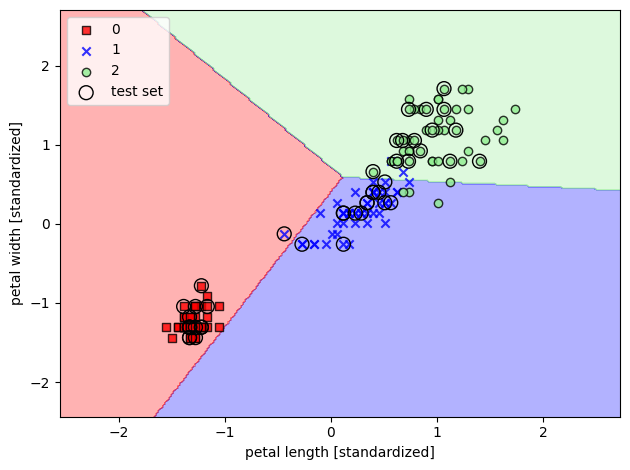

In [10]:
#train ppn using the standardized training set
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=ppn, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()
#not coverging because not linearly separable

<>:18: SyntaxWarning: invalid escape sequence '\p'
<>:18: SyntaxWarning: invalid escape sequence '\p'
C:\Users\monae\AppData\Local\Temp\ipykernel_21792\1014826950.py:18: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('$\phi (z)$')


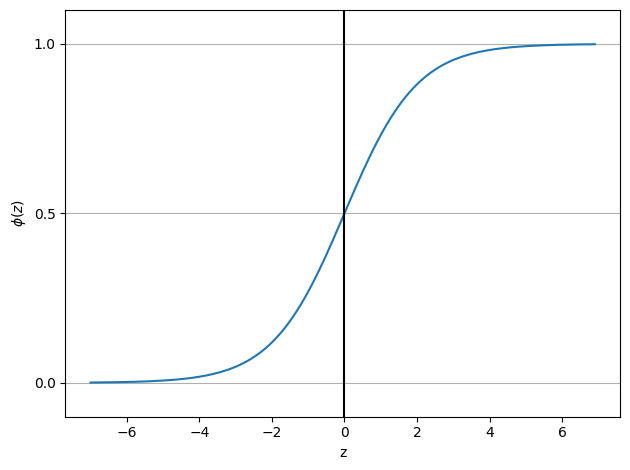

In [11]:
#use of logistic regression intuition and conditional probabilities
#odds ratio: odds in favor of x event
import matplotlib.pyplot as plt
import numpy as np

#interested in the inverse of logit (meaning we want the prob that x sample belongs in y class)
#referred to as (logistic( sigmoid function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
#plt.savefig('images/03_02.png', dpi=300)
plt.show()
#approaching 1 towards infinity and 0 towards negative infinity, so yeah real numbers in and puts out values [0,1]
#sometimes have interest in the estimation of class membership as well so no threshold function
#e.g. not only IF it will rain but also the chance of rain

<>:23: SyntaxWarning: invalid escape sequence '\p'
<>:23: SyntaxWarning: invalid escape sequence '\p'
C:\Users\monae\AppData\Local\Temp\ipykernel_21792\3749873446.py:23: SyntaxWarning: invalid escape sequence '\p'
  plt.xlabel('$\phi$(z)')


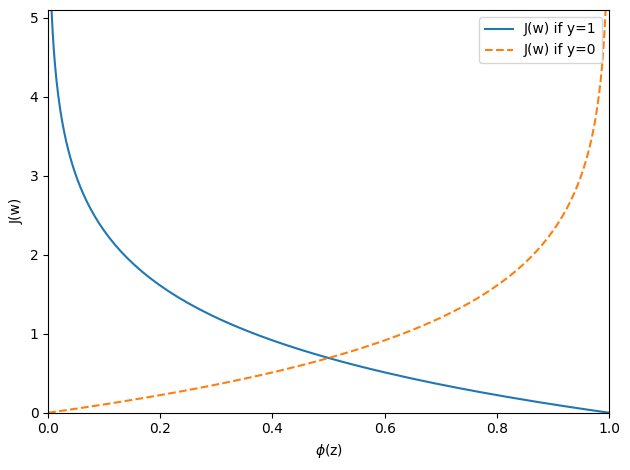

In [12]:
#learn weights of logistic cost function
#log reduces possibility of numerical underflow (meaning that the calculation is more 
#precise than the machine's memory can actually represent, read: itty bitty number)
# convert product into summation of factors, easier derivative through addition trick
def cost_1(z):
    return - np.log(sigmoid(z))


def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
#as cost approaches 0, correctly predict that it belongs to class 1
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
#as cost approaches 0, correctly predict y = 0; if wrong, heads towards infinity
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
#goal is to penalize wrong predictions with increasingly larger cost
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_04.png', dpi=300)
plt.show()

In [13]:
class LogisticRegressionGD(object):
    """Logistic Regression Classifier using gradient descent.
    Will leave it this time, but the parameters and attributes are the same as they've always been
    short of cost_ now being logistic cost function... in a logistic regression, what a surprise!
    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.
      
    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Logistic cost function value in each epoch.

    Convert Adaline to LRGD:
        change cost function
        linear activation -> sigmoid activation
        [-1,1] -> [0,1] thresholds
    """
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.
        same as usual
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        # equivalent to:
        # return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


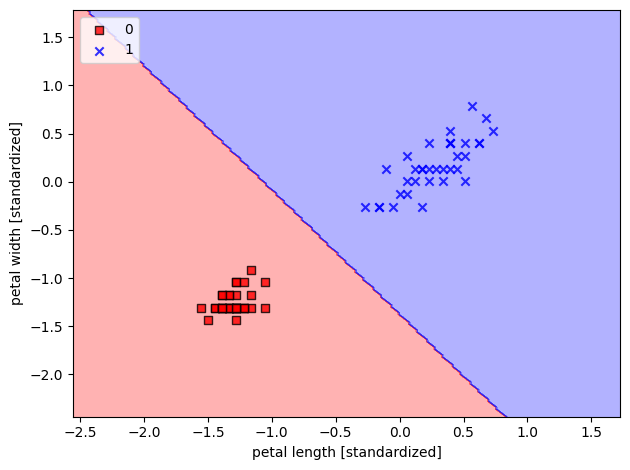

In [14]:
#brief reminder that LR models only works in the binary classifications, because in short, it aint built like that
#test against setosa v versicolor
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]

lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset,
         y_train_01_subset)

plot_decision_regions(X=X_train_01_subset, 
                      y=y_train_01_subset,
                      classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_05.png', dpi=300)
plt.show()

C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


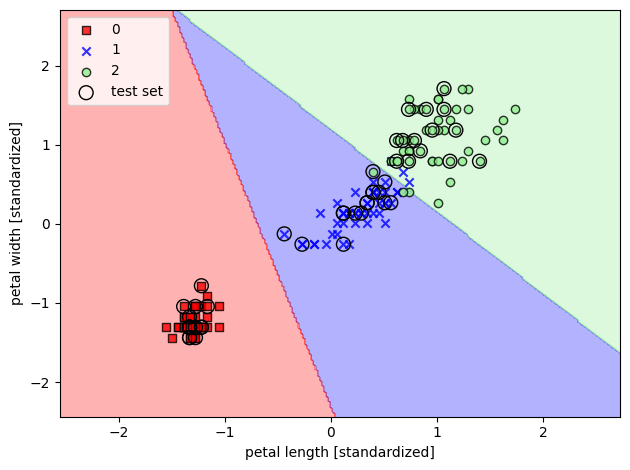

In [15]:
#train logistic regression with scikit, which is OvR by default
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

#C, inverse of regularization strength
#lbfgs handles multiclass problems and multinomial loss; default now but wasn't always
#multi_class = 'ovr' is depreciated, use the wrap class instead now
lr = OneVsRestClassifier(LogisticRegression(C=100.0, random_state=1, solver='lbfgs'))
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('images/03_06.png', dpi=300)
plt.show()

In [16]:
#predict the prob of the test samples 0, 1, 2; each row is a flower's membership probabilities
#columns sum to one
#highest value in row 1 is .855, first flower is likely to be virginica
lr.predict_proba(X_test_std[:3, :])

array([[6.63770505e-09, 1.44747233e-01, 8.55252760e-01],
       [8.34031210e-01, 1.65968790e-01, 3.20815954e-13],
       [8.48822884e-01, 1.51177116e-01, 2.57998350e-14]])

In [17]:
#prove that they sum to 1
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [18]:
#argmax function can give the predicted class labels by IDing largest column in each row
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)
#so array says 2, 0, 0; meaning viriginica, setosa, setosa

array([2, 0, 0], dtype=int64)

In [19]:
#labels from preceding conditional probs can also just call the predict method directly
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [20]:
"""
Caution: sklearn expects a 2-D array, so would need to convert a single row slice to that format
    that is, if you want a single flower sample
"""
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be rem

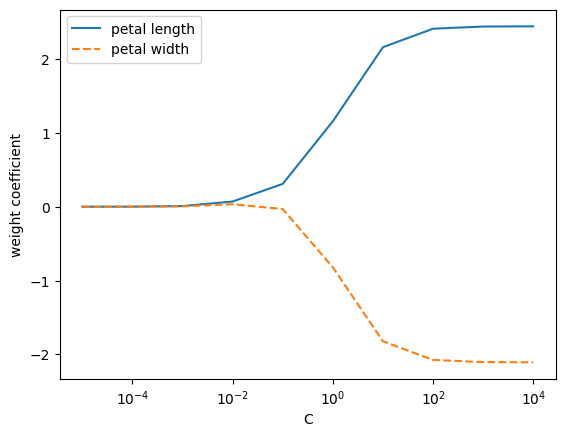

In [21]:
#handling overfitting through regularization
weights, params = [], []
for c in np.arange(-5, 5):
    #gave it two minutes, haven't figured out how to rewrite this with the wrap class so think about it later
    #note to self onevsrestclassifier.lr doesn't work
    lr = LogisticRegression(C=10.**c, random_state=1,
                            solver='lbfgs',
                            multi_class = 'ovr')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
#plt.savefig('images/03_08.png', dpi=300)
plt.show()

C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


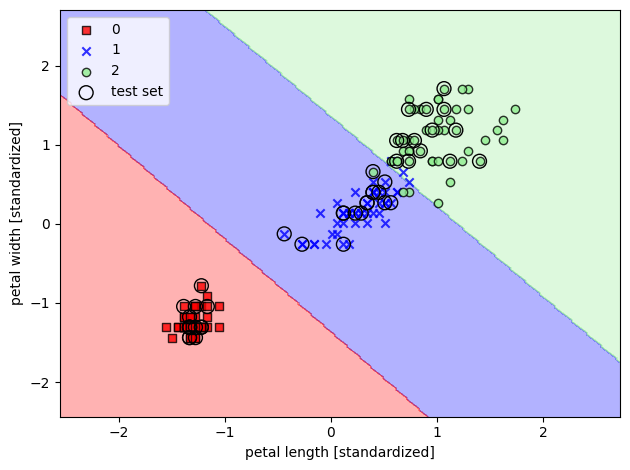

'\npractically, LR will have similar results to a linear SVM\nLR:\n    tries to maximize the conditional likelihoods of the training data\n    susceptible to outliers\n    simpler and more easily implemented\n    easier to update,\n\nSVM:\n    cares more about the points closest to the decision boundaries\n'

In [22]:
"""
SVC = Support Vector Machine aims to maximize the margin
didn't like this explanation
support vectors are the line made by the closest training samples
margin = distance between the support vectors (positive versus negative), 
    the decision boundary is in the margin somewhere
ideally, the decision boundary is somewhere in the middle that allows the most space between the decision boundary
    and the training sample
    decreases overfitting

soft-margin classification, came about through the slack variable
    idea is to support the convergence of the optimization in nonlinearly separable data where there are 
        misclassifications
    ofc with cost penalization

back to that C variable
    small value, smaller error penalties < C
        accepts more misclassification in favor of a larger margin (more generalizable, ofc within reason)
    C < large value, large error penalties
        generally will cause narrower margins which can overfit
    control the width of the margin, tune bias-variance trade off
Regularization: decreasing the value of C increases bias, lowers the variance
"""
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, 
                      y_combined,
                      classifier=svm, 
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_11.png', dpi=300)
plt.show()

"""
practically, LR will have similar results to a linear SVM
LR:
    tries to maximize the conditional likelihoods of the training data
    susceptible to outliers
    simpler and more easily implemented
    easier to update,

SVM:
    cares more about the points closest to the decision boundaries
"""

In [23]:
"""
perceptron and lr come from liblinear library; SVM comes from libsvm library
Native Python solutions would be slower in training large amounts of linear classifiers
BUT it can be the case that some datasets are too big for the ocmputer's memory, so alternatives are available
through the SGDCLassifier
    supports online learning with the partial fit
    similar to stochastic gradient algo
    can initialize SGD version of all with default parameters like this
"""
from sklearn.linear_model import SGDClassifier

ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
svm = SGDClassifier(loss='hinge')

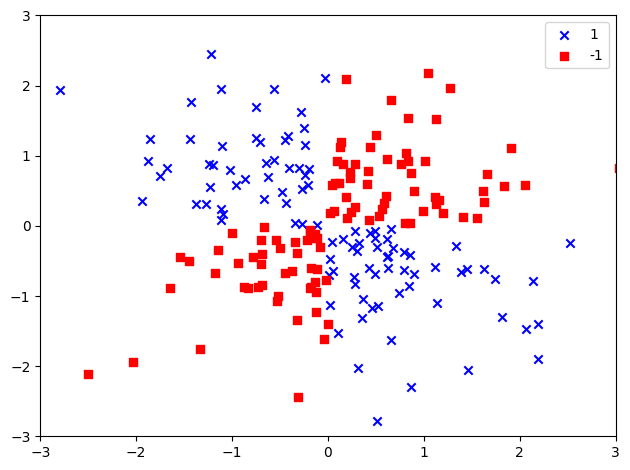

In [24]:
#SVMs are also popilar for their easy kernelizability in solving nonlinear classification problems
#creating simple dataset in form of XOR gate with logical)or from NumPy, 
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)
#200 samples broken into 2, 100 assigned 1 and the other assigned -1
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0,
                       X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)

plt.scatter(X_xor[y_xor == 1, 0],
            X_xor[y_xor == 1, 1],
            c='b', marker='x',
            label='1')
plt.scatter(X_xor[y_xor == -1, 0],
            X_xor[y_xor == -1, 1],
            c='r',
            marker='s',
            label='-1')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
#plt.savefig('images/03_12.png', dpi=300)
plt.show()

C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


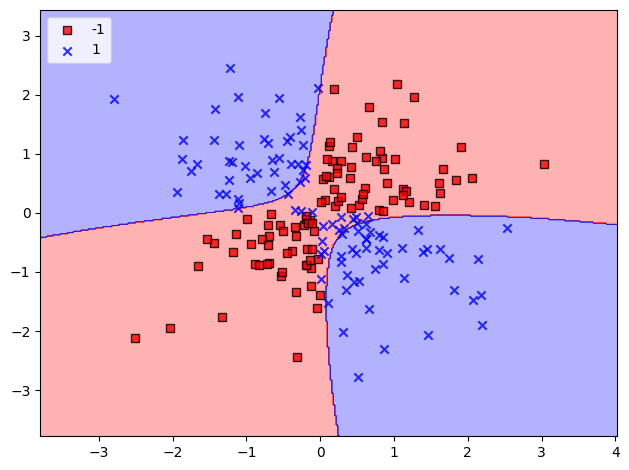

In [26]:
"""
kernel trick to find separating hyperplanes in higher dimensional space
map function to transform training data to higher-dimensional feature space, train with that
    problem is this is computationally expensive
    so kernel trick!
        tldr: replace dot product with a kernel function
        common kernal is Radial Basis Function (rbf), aka Gaussian kernel
well what is? similarity function between a pair of samples
    minus inverts distance into similarity score
    exponent makes for a range of [0,1] [dissimilar, similar]
Gamma = cut-off parameter
    increase influence/reach then tighter/bumpier decision boundary
"""
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor,
                      classifier=svm)

plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_14.png', dpi=300)
plt.show()

C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


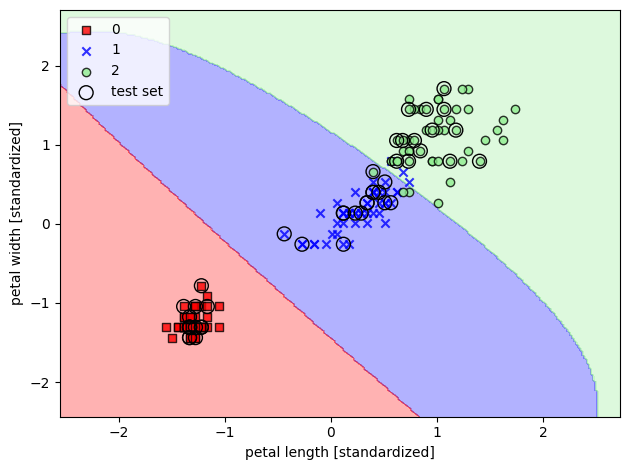

In [27]:
"""apply kernel to iris data
small value for gamma, so soft boundary
"""
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_15.png', dpi=300)
plt.show()

C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:28: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],
C:\Users\monae\AppData\Local\Temp\ipykernel_21792\2032430309.py:42: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):


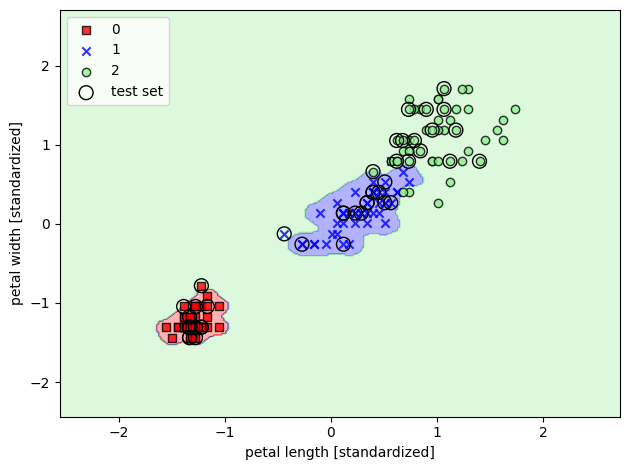

In [28]:
"""again but increase value for gamma
    tighter boundary but also lol, its giving "this is virginica's world, you all just live in it!"
    it does what it needs to do but man it's gonna be weird with stuff it hasn't seen!
    In short: gamma? super important to controlling overfitting
"""
svm = SVC(kernel='rbf', random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_16.png', dpi=300)
plt.show()

In [ ]:
#lets get some decision trees going!
"""Decision Trees
    interpretability is the name of our game!
    break down data by a series of questions, basically
    "is width >= 2.8cm", if yes then [flower], if no [other flowers] would be a basic set
    but essentially a series of cut-off values

    this looks like how I designed my automation flow, which item is going to catch the most entries &
    trickle down from there to give me highest pay off at the top to minimize the runtime by catching
    majority immediately.

    Tree root, split on feature that gives largest Information Gain (IG)
    Can do this iteratively, repeat at each child node until a decision has been reached (leaves are pure)
    practically though this can overfit the model
    so prune by giving limits for the max depth of a tree

    Set 
"""
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini impurity', 'Misclassification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('impurity index')
#plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#build from sklearn
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(criterion='gini', 
                                    max_depth=4, 
                                    random_state=1)
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()

In [ ]:
from sklearn import tree

tree.plot_tree(tree_model)
#plt.savefig('images/03_21_1.pdf')
plt.show()

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_model,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

In [ ]:
#weak + strong learners through random forests
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_22.png', dpi=300)
plt.show()

In [ ]:
#k-nearest neighbors, lazy learning algo
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')
knn.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined, 
                      classifier=knn, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()